In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, plot_metrics, plot_metric, make_axis_great_again, plot_epochs
from post.utils import parse_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '06.05_12.05_solving_the_MLP_problem'

human36m_alg_AlgebraicTriangulationNet@11.05.2021-11:41:49 (from /home/stefano/Scuola/now/thesis/milestones/06.05_12.05_solving_the_MLP_problem/15420328.out)
training on 12, evaluating on 5
found 1000 epochs
training loss in [42777.1, 52032.8]
training metrics in [439.8, 64678.5]
eval metrics in [484.8, 2668.3]
- plotted "L2 on T (min = 30.6, max = 60.9, last = 30.6)" metrics [0.0, 1.0] in epochs [2, 1500]
- plotted "L2 proj pose (min = 21388.6, max = 26016.4, last = 21647.9)" metrics [0.0, 1.0] in epochs [2, 1500]
- plotted "training metrics" metrics [439.8, 64678.5] in epochs [2, 1500]
- plotted "eval metrics" metrics [484.8, 2668.3] in epochs [2, 1500]
human36m_alg_AlgebraicTriangulationNet@11.05.2021-21:52:00 (from /home/stefano/Scuola/now/thesis/milestones/06.05_12.05_solving_the_MLP_problem/15500638.out)
training on 11872, evaluating on 703
found 14 epochs
training loss in [5325938.3, 12391450.6]
training metrics in [190.0, 268.1]
eval metrics in [215.6, 251.6]
- plotted "geodesi

Text(0.5, 0.98, 'cam2cam estimation (using GT keypoints using L2 projection loss')

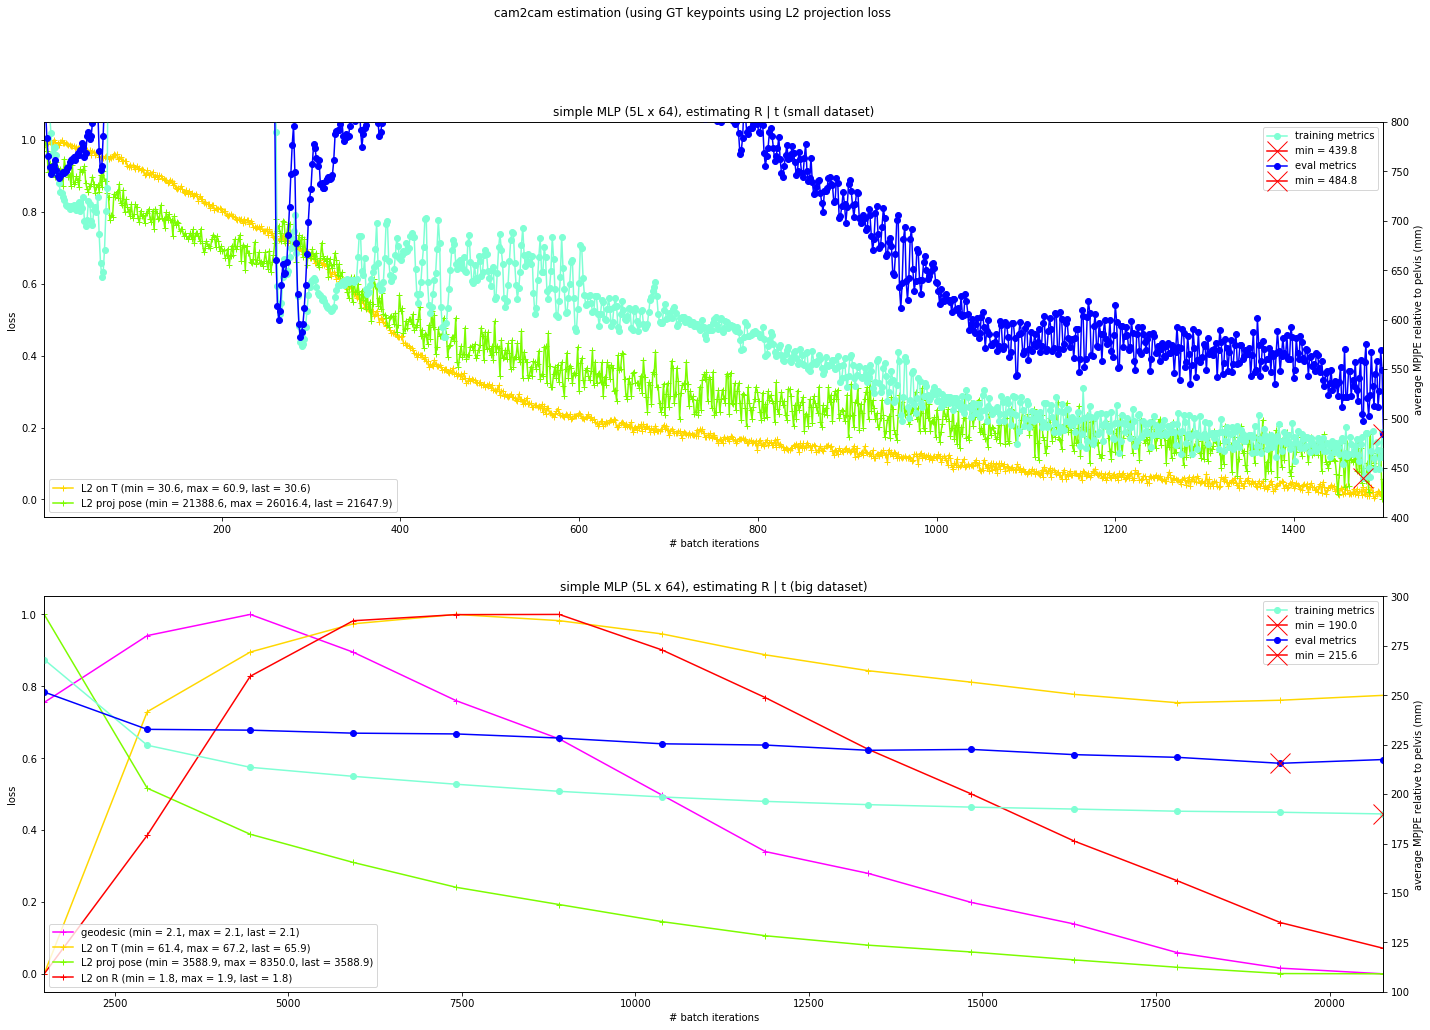

In [17]:
fig, axis = get_figa(2, 1, heigth=8, width=24)

training_batch_size = 8

job_id = '15420328'
exp_name, train_data_amount, _, epochs = parse_job_log(current_milestone / '{}.out'.format(job_id))
batch_amount_per_epoch = train_data_amount / training_batch_size
xrange = np.arange(1, len(epochs) + 1) * batch_amount_per_epoch
metrics_ylim = [4e2, 8e2]

ax = axis.ravel()[0]
plot_epochs(
    ax, epochs, xrange,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    normalize_loss=(0, 1),
    title='simple MLP (5L x 64), estimating R | t (small dataset)',
    metric_ylabel='average MPJPE relative to pelvis (mm)',
    xlabel='# batch iterations'
)
make_axis_great_again(ax, xlim=xrange, ylim=None, hide_y=False)

job_id = '15500638'
exp_name, train_data_amount, _, epochs = parse_job_log(current_milestone / '{}.out'.format(job_id))
batch_amount_per_epoch = train_data_amount / training_batch_size
xrange = np.arange(1, len(epochs) + 1) * batch_amount_per_epoch
metrics_ylim = [1e2, 3e2]

ax = axis.ravel()[1]
plot_epochs(
    ax, epochs, xrange,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    normalize_loss=(0, 1),
    title='simple MLP (5L x 64), estimating R | t (big dataset)',
    metric_ylabel='average MPJPE relative to pelvis (mm)',
    xlabel='# batch iterations'
)
make_axis_great_again(ax, xlim=xrange, ylim=None, hide_y=False)

fig.suptitle('cam2cam estimation (using GT keypoints using L2 projection loss')
# T_recovered.png